This notebook is me pulling apart and rebuilding OOP COCO and CocoGenerator class code into a single function, so that I can just see the category names corresponding to base-RetNet predictions.

The lazy way of just initializing a `CocoGenerator` object in order to use its method functions to convert labels into categories didn't work, as it reset the random number seed each time it was initialized -->> leading to the exact same image being displayed each time the cell was run, unless the random seed was explicitly reset.

This ended up becomming a tour of familiarization with the [keras-retinanet/.../coco.py](https://github.com/fizyr/keras-retinanet/blob/master/keras_retinanet/preprocessing/coco.py) and [cocodataset/.../coco.py](https://github.com/cocodataset/cocoapi/blob/master/PythonAPI/pycocotools/coco.py) (keras_retinanet.preprocessing.coco.CocoGenerator & pycocotools.COCO) class code.

I ended up understanding the code a lot better, and succeeded in making my little function to convert labels to names and vice versa. I'll make a neat demo in another notebook.

`Wayne Nixalo - 03:21 02-Jan 2018`

In [8]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2


import keras
import keras.preprocessing.image
from keras_retinanet.preprocessing.coco import CocoGenerator

import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import time

import tensorflow as tf

from PIL import Image
from keras_retinanet.utils.image import preprocess_image # <-- this is the CocoGenerator.preprocess_image() method
from keras_retinanet.utils.image import resize_image # <-- this is CocoGenerator.resize_image()

def get_session():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    return tf.Session(config=config)

keras.backend.tensorflow_backend.set_session(get_session())

from keras_retinanet.models.resnet import custom_objects

model = keras.models.load_model('data/retinanet-model/resnet50_coco_best_v1.2.2.h5', custom_objects=custom_objects)

/Users/WayNoxchi/Miniconda3/envs/tfkeras/lib/python3.6/site-packages/keras/models.py:271: UserWarning: Output "non_maximum_suppression_2" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "non_maximum_suppression_2" during training.
  sample_weight_mode=sample_weight_mode)


In [9]:
def detect_one(image=None, threshold=0.5, mode=1, COCO_Label=False):
    if COCO_Label:
        # create image data generator object
        val_image_data_generator = keras.preprocessing.image.ImageDataGenerator()

        # create a generator for testing data
        val_generator = CocoGenerator('data/COCO', 'val2017', val_image_data_generator, batch_size=1,)
    
    # copy image to draw on
    draw = image.copy()
    draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)
    
    # preprocess image for network
    image = preprocess_image(image)
    image, scale = resize_image(image)
    
    # process image
    start = time.time()
    _,_, detections = model.predict_on_batch(np.expand_dims(image, axis=0))
    print("processing time: ", time.time() - start)
    
    # compute predicted labels and scores
    predicted_labels = np.argmax(detections[0, :, 4:], axis=1)
    scores = detections[0, np.arange(detections.shape[1]), 4 + predicted_labels]
    
    label = predicted_labels[0]
    label_name = val_generator.label_to_name(label) if COCO_Label else label
    
    # correct for image scale
    detections[0, :, :4] /= scale
    
    # visualize detections
    count = 0
    max_score = -1
    
    caption = ""
    # pull out the most confident predicted label
    b = detections[0, np.argmax(scores), :4].astype(int)

    # draw the bounding box & label+score on the image
    cv2.rectangle(draw, (b[0], b[1]), (b[2], b[3]), (0,0,255), 3)
    caption = f'Pilot "{label_name}" {scores[np.argmax(scores)]:.3f}'
    cv2.putText(draw, caption, (b[0], b[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 1., (0,0,0), 4, cv2.LINE_AA)
    cv2.putText(draw, caption, (b[0], b[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 1., (255,255,255), 2, cv2.LINE_AA)
    
    if mode == 1:
        # print next 4 top labels
        for idx, (label, score) in enumerate(zip(predicted_labels[1:5], scores[1:5])):
            label_name = val_generator.label_to_name(label) if COCO_Label else label
            
            # get bonding box
            b = detections[0, idx, :4].astype(int)
            # draw the bounding box & label+score on the image
            cv2.rectangle(draw, (b[0], b[1]), (b[2], b[3]), (0,255,0), 2)
            caption = f'`{label_name}` {scores[np.argmax(scores)]:.3f}'
            cv2.putText(draw, caption, (b[0], b[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,0,0), 3, cv2.LINE_4)
            cv2.putText(draw, caption, (b[0], b[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255,255,255), 1, cv2.LINE_4)
        
#     print(caption)
#     print(f'Bounding Box: {b}')
    
#     print(predicted_labels)
#     if COCO_Label:
#         print([val_generator.label_to_name(label) for label in predicted_labels])

    for idx, (label,score) in enumerate(zip(predicted_labels[:5], scores[:5])):
        label = val_generator.label_to_name(label) if COCO_Label else label
        bb = detections[0,idx, :4].astype(int)
        print(f'{label}: {score} -- {bb}')
    
    plt.figure(figsize=(8, 8))
    plt.axis('off')
    plt.imshow(draw)
    plt.show()
    
def detect_pilot(trainpath = 'data/train/', folder="", threshold=0.5, mode=0, COCO_Label=False):
    if folder == "":
        print("No folder specified")
        return

    fpaths = [trainpath + folder + '/' + fname for fname in os.listdir(trainpath + folder)]

#     np.random.seed()
    idx = np.random.choice(np.arange(len(fpaths)))
    print(f'Image path: {fpaths[idx]}')

    image = fpaths[idx]

    image = Image.open(image)
    image = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)
#     plt.imshow(image)
    
    detect_one(image, threshold=threshold, mode=mode, COCO_Label=COCO_Label)

In [10]:
trainpath = 'data/train/'
folders = os.listdir(trainpath)

Image path: data/train/005452-005591/005584.jpg
loading annotations into memory...
Done (t=0.72s)
creating index...
index created!
processing time:  5.713995933532715
Pilot "airplane" 0.363
Bounding Box: [  3  47 400 399]
[ 4  0  0 24  8  4  0 24  8  8  0 56 24 24  0 24  0 24  0  8 67 41  7 24  0
  0 24  0 24  0 41  0  0 67  4  0 24  0  0 24 68  0 24 63  0  7  0  0 27 24
 56  0  0 41  0  8  0  4  0 39  0 56  8  0 24 13 24  0  4  4  0 24 25  0  0
  2 39  0  0 41  0  4 24 24 67  0 24 24  0  0  0  0  0  4 24  8  0 13 56  8
  0 24  0 62  0 24 24  0 14 24 56  0 24  0 24 62 56  0  0 24 14  0  0  0  8
 60  0 30 24 41 24  0  8  0  0 67 24 27  0 28 13 24 13  2  0 24  0  0 28  0
  8  0 30  0  0 24  0 27 24  4 56 24  0  0  8  0 24  0  0 34 24 24  0  0  0
  0  0 60  0  0  0 24 24 56  0  0 27  0 24 30  0  0 71 67  0 24  0  0  0  8
 24  0 30  0  0  0 41 24 24  0 14  4  0  0  0  0  2 24 66 24  0 24 73  0  0
 56 27  0  0 66  0  0 56  0 24  0 30 24  0  0 42  0 34  0 39 14 58  0  0  0
 40  0 46  0  4  0

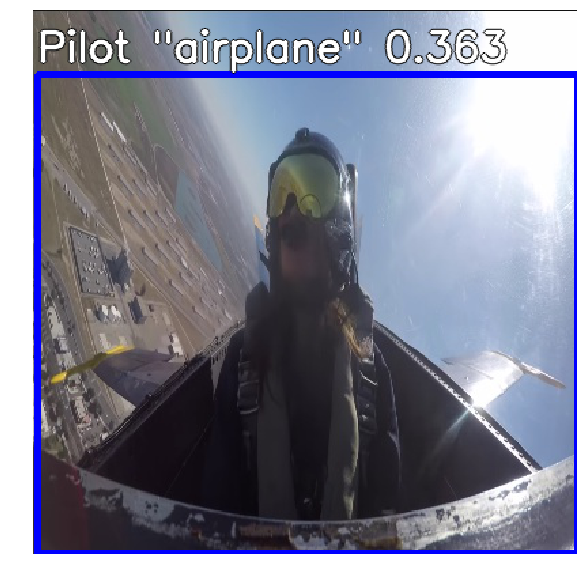

In [24]:
detect_pilot(folder = np.random.choice(folders), mode=0, COCO_Label=True)

In [35]:
folders

['002439-003316',
 '006242-006439',
 '001883-002438',
 '006673-006860',
 '004402-004684',
 '001435-001882',
 '005592-006111',
 '003604-003904',
 '001190-001434',
 '007365-007636',
 '003905-004151',
 '006861-007364',
 '005106-005451',
 '005452-005591',
 '000413-000569',
 '006112-006241',
 '003317-003603',
 '004152-004401',
 '000000-000412',
 '004685-005105',
 '006549-006672',
 '000570-001189',
 '006440-006548']

In [39]:
np.random.choice(folders)

'002439-003316'

In [41]:
folder = np.random.choice(folders)
fpaths = [trainpath + folder + '/' + fname for fname in os.listdir(trainpath + folder)]

idx = np.random.choice(np.arange(len(fpaths)))
print(f'Image path: {fpaths[idx]}')

Image path: data/train/007365-007636/007596.jpg


Image path: data/train/001883-002438/002049.jpg
loading annotations into memory...
Done (t=0.67s)
creating index...
index created!
processing time:  5.4021618366241455
person: 0.35310813784599304 -- [137 106 339 397]
handbag: 0.025331970304250717 -- [293 302 339 396]
suitcase: 0.02239249087870121 -- [140 296 346 394]
person: 0.018730495125055313 -- [ 40  74 186 396]
backpack: 0.01697639562189579 -- [132 290 171 394]


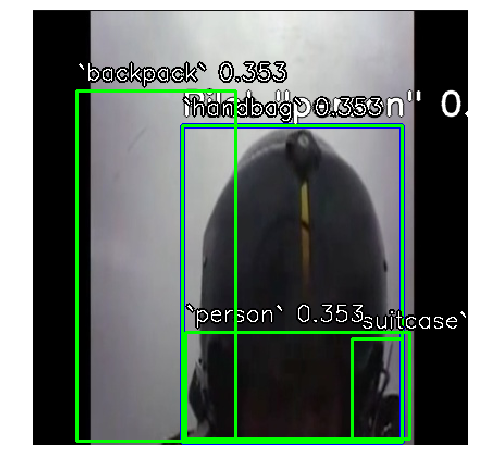

In [193]:
np.random.seed()
detect_pilot(folder = np.random.choice(folders), mode=1, COCO_Label=True)

for some reason the same photo keeps repeating. Unless the seed is explicitly set, the 2nd and all subsequent images will be `data/train/005106-005451/005414.jpg`

I think it's because one of the COCO imports are playing with the seed / random number generator somewhere -- since this doesn't happen in another notebook where the only different code is a lack of any imports.

---

Yep I've confirmed it. When `COCO_Label=True`, the CocoGenerator is initialized. This probably resets the NumPy RNG to whatever seed the devs specified -- probably in order to ensure reproducibility by ensuring the exact same order of batches.

I can either tear apart the pycocotools code and find out how to pull the labels from the `.json` annotations file, or check if there's a parameter to not reset the random seed.

Image path: data/train/006673-006860/006824.jpg
processing time:  6.024749994277954
0: 0.64698725938797 -- [ 34  66 293 381]
0: 0.40309086441993713 -- [204  68 310 365]
27: 0.22042369842529297 -- [223 120 284 320]
26: 0.1658572554588318 -- [163 316 197 376]
0: 0.1498953402042389 -- [255  57 294 177]


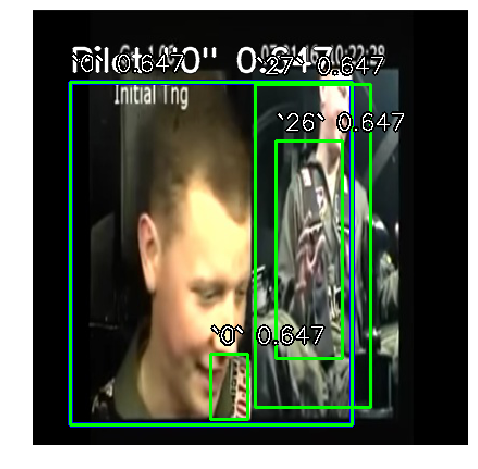

In [19]:
detect_pilot(folder=np.random.choice(folders), mode=1, COCO_Label=False)

Image path: data/train/006549-006672/006602.jpg
loading annotations into memory...
Done (t=0.51s)
creating index...
index created!
processing time:  5.953499794006348
person: 0.5510090589523315 -- [138 159 317 396]
car: 0.11029143631458282 -- [ 44 316 176 396]
person: 0.049425311386585236 -- [ 64 314 311 403]
car: 0.04117105156183243 -- [ 76 332 118 392]
person: 0.04048789292573929 -- [ 37 180 215 384]


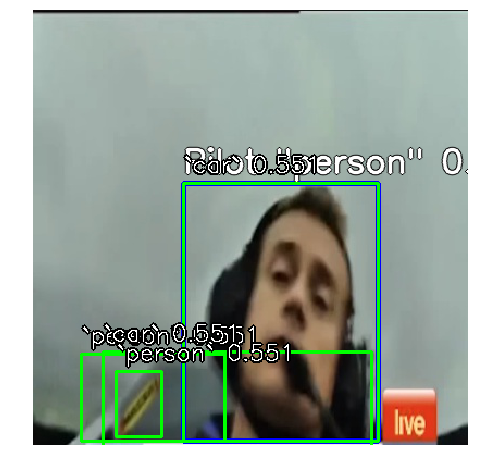

In [10]:
np.random.seed()
detect_pilot(folder=np.random.choice(folders), mode=1, COCO_Label=True)

In [216]:
nums = np.arange(100)

In [282]:
np.random.choice(nums)

68

In [ ]:
# let's see what pycocotools.coco.COCO is
# https://sourcegraph.com/github.com/cocodataset/cocoapi@master/-/blob/PythonAPI/pycocotools/coco.py#L179
# Okay, I want loadCats from COCO.

# def _isArrayLike(obj):
#     return hasattr(obj, '__iter__') and hasattr(obj, '__len__')

# def loadCats(self, ids=[]):
#     if _isArrayLike(ids):
#         return [self.cats[id] for id in ids]
#     elif type(ids) == int:
#         return [self.cats[ids]]

def getCatIds(self, catNms=[], supNms=[], catIds=[]):
    catNms = catNms if _isArrayLike(catNms) else [catNms]
    supNms = supNms if _isArrayLike(supNms) else [supNms]
    catIds = catIds if _isArrayLike(catIds) else [catIds]

    if len(catNms) == len(supNms) == len(catIds) == 0:
        cats = self.dataset['categories']
    else:
        cats = self.dataset['categories']
        cats = cats if len(catNms) == 0 else [cat for cat in cats if cat['name']          in catNms]
        cats = cats if len(supNms) == 0 else [cat for cat in cats if cat['supercategory'] in supNms]
        cats = cats if len(catIds) == 0 else [cat for cat in cats if cat['id']            in catIds]
    ids = [cat['id'] for cat in cats]
    return ids

annotation_file = data_dir + 'annotations' + 'instances_' + set_name + '.json'
dataset = json.load(open(annotation_file, 'r'))

In [ ]:
# def __init__(self, data_dir, set_name, image_data_generator, *args, **kwargs)
val_generator = CocoGenerator('data/COCO', 'val2017', val_image_data_generator, batch_size=1,)

data_dir = 'data/COCO'
# set_name = 'val2017' # ?

from pycocotools.coco import COCO

coco = COCO(os.path.join(data_dir, 'annotations', 'instances_', + set_name + '.json'))

# load class names (name -> label)
categories = self.coco.loadCats(self.coco.getCatIds())
categories.sort(key=lambda x: x['id'])

self.classes             = {}
self.coco_labels         = {}
self.coco_labels_inverse = {}
for c in categories:
    self.coco_labels[len(self.classes)] = c['id']
    self.coco_labels_inverse[c['id']] = len(self.classes)
    self.classes[c['name']] = len(self.classes)

self.labels = {}
for key, value in self.classes.items():
    self.labels[value] = key

# load the reverse (label -> name)
def label_to_name(self, label):
    return self.labels[label]



Testing a functional version of classes COCO and CocoGenerator, to *just* have the ability to grab the label to name conversion.

In [86]:
# Functional Implementation of COCO and CocoGenerator classes for labels
def load_classes_and_labels(data_dir='data/COCO', set_name='val2017'):
    from collections import defaultdict
    import json
    import time
    import os

    ### class COCO
    # __init__(self, annotation_file=None)
    dataset, anns, cats, imgs = dict(), dict(), dict(), dict()

    annotation_file = os.path.join(data_dir, 'annotations', 'instances_' + set_name + '.json')
    # from: class CocoGenerator.__init__: self.coco = COCO(os.path.join(data_dir, 'annotations', 'instances_' + set_name + '.json'))

    if not annotation_file == None:
        print('loading annotations...')
        tic = time.time()
        dataset = json.load(open(annotation_file, 'r'))
        assert type(dataset)==dict, f'annotation file format {type(dataset)} not supported'
        print(f'Done (t={time.time()-tic:0.2f}s)')

    # createIndex(self)
    print('creating index...')
    anns, cats, imgs = {}, {}, {}
    imgToAnns, catToImgs = defaultdict(list), defaultdict(list)
    if 'annotations' in dataset:
        for ann in dataset['annotations']:
            imgToAnns[ann['image_id']].append(ann)
            anns[ann['id']] = ann
            
        if 'categories' in dataset:
            for ann in dataset['annotations']:
                catToImgs[ann['category_id']].append(ann['image_id'])

    if 'images' in dataset:
        for img in dataset['images']:
            imgs[img['id']] = img

    if 'categories' in dataset:
        for cat in dataset['categories']:
            cats[cat['id']] = cat

    print('index created!')
#     print(cats)
#     return cats

    # getCatIDs
    catNms=[]; supNms=[]; catIds=[]     # just to preserve some semblance of the OOP method form

    catNms = catNms if _isArrayLike(catNms) else [catNms]
    supNms = supNms if _isArrayLike(supNms) else [supNms]
    catIds = catIds if _isArrayLike(catIds) else [catIds]

    if len(catNms) == len(supNms) == len(catIds) == 0:
        cats_ = dataset['categories']
    else:
        cats_ = dataset['categories']
        cats_ = cats_ if len(catNms) == 0 else [cat for cat in cats_ if cat['name']          in catNms]
        cats_ = cats_ if len(supNms) == 0 else [cat for cat in cats_ if cat['supercategory'] in supNms]
        cats_ = cats_ if len(catIds) == 0 else [cat for cat in cats_ if cat['id']            in catIds]
    ids = [cat['id'] for cat in cats_]

#     print(len(ids))
#     print(ids)

#     print(len(cats))
#     print(cats)
#     return cats, ids
    
    # loadCats(self, ids=[])
    if _isArrayLike(ids):
        categories = [cats[id] for id in ids]
    elif type(ids) == int:
        categories = [cats[ids]]

    ### class CocoGenerator(Generator)
    # __init__(self, data_dir, set_name, image_data_generator, *args, **kwargs)

    # load_classes(self)
    categories.sort(key=lambda x: x['id'])

    classes             = {}
    coco_labels         = {}
    coco_labels_inverse = {}
    for c in categories:
        coco_labels[len(classes)] = c['id']
        coco_labels_inverse[c['id']] = len(classes)
        classes[c['name']] = len(classes)

    labels = {}
    for key, value in classes.items():
        labels[value] = key

    return classes, labels

def _isArrayLike(obj):
    return hasattr(obj, '__iter__') and hasattr(obj, '__len__')

# name_to_label(self,name)
def name_to_label(name):
    return classes[name]

# label_to_name(self, label)
def label_to_name(label):
    return labels[label]

classes, labels = load_classes_and_labels()
# cats, ids = load_classes_and_labels()
# cats = load_classes_and_labels(); cats

loading annotations...
Done (t=1.22s)
creating index...
index created!


In [100]:
classes['airplane']

4

In [107]:
print(f'{classes["person"]}->{label_to_name(classes["person"])}')
print(f'{labels[0]}->{name_to_label(labels[0])}')
print()
print(f'classes["person"] => {classes["person"]}')
print(f'labels[0]         => {labels[0]}')

0->person
person->0

classes["person"] => 0
labels[0]         => person


Yay.. *iiitt... wooooooooooooorks.*

It's 3:10 AM. Wolf Moon. Gluten Nacht.

In [90]:
list(zip(labels, classes))

[(0, 'person'),
 (1, 'bicycle'),
 (2, 'car'),
 (3, 'motorcycle'),
 (4, 'airplane'),
 (5, 'bus'),
 (6, 'train'),
 (7, 'truck'),
 (8, 'boat'),
 (9, 'traffic light'),
 (10, 'fire hydrant'),
 (11, 'stop sign'),
 (12, 'parking meter'),
 (13, 'bench'),
 (14, 'bird'),
 (15, 'cat'),
 (16, 'dog'),
 (17, 'horse'),
 (18, 'sheep'),
 (19, 'cow'),
 (20, 'elephant'),
 (21, 'bear'),
 (22, 'zebra'),
 (23, 'giraffe'),
 (24, 'backpack'),
 (25, 'umbrella'),
 (26, 'handbag'),
 (27, 'tie'),
 (28, 'suitcase'),
 (29, 'frisbee'),
 (30, 'skis'),
 (31, 'snowboard'),
 (32, 'sports ball'),
 (33, 'kite'),
 (34, 'baseball bat'),
 (35, 'baseball glove'),
 (36, 'skateboard'),
 (37, 'surfboard'),
 (38, 'tennis racket'),
 (39, 'bottle'),
 (40, 'wine glass'),
 (41, 'cup'),
 (42, 'fork'),
 (43, 'knife'),
 (44, 'spoon'),
 (45, 'bowl'),
 (46, 'banana'),
 (47, 'apple'),
 (48, 'sandwich'),
 (49, 'orange'),
 (50, 'broccoli'),
 (51, 'carrot'),
 (52, 'hot dog'),
 (53, 'pizza'),
 (54, 'donut'),
 (55, 'cake'),
 (56, 'chair'),
 (57

In [95]:
# val_generator.classes
val_generator.labels

'person'

In [96]:
val_generator.classes['person']

0

In [82]:
cats

[{'id': 1, 'name': 'person', 'supercategory': 'person'},
 {'id': 2, 'name': 'bicycle', 'supercategory': 'vehicle'},
 {'id': 3, 'name': 'car', 'supercategory': 'vehicle'},
 {'id': 4, 'name': 'motorcycle', 'supercategory': 'vehicle'},
 {'id': 5, 'name': 'airplane', 'supercategory': 'vehicle'},
 {'id': 6, 'name': 'bus', 'supercategory': 'vehicle'},
 {'id': 7, 'name': 'train', 'supercategory': 'vehicle'},
 {'id': 8, 'name': 'truck', 'supercategory': 'vehicle'},
 {'id': 9, 'name': 'boat', 'supercategory': 'vehicle'},
 {'id': 10, 'name': 'traffic light', 'supercategory': 'outdoor'},
 {'id': 11, 'name': 'fire hydrant', 'supercategory': 'outdoor'},
 {'id': 13, 'name': 'stop sign', 'supercategory': 'outdoor'},
 {'id': 14, 'name': 'parking meter', 'supercategory': 'outdoor'},
 {'id': 15, 'name': 'bench', 'supercategory': 'outdoor'},
 {'id': 16, 'name': 'bird', 'supercategory': 'animal'},
 {'id': 17, 'name': 'cat', 'supercategory': 'animal'},
 {'id': 18, 'name': 'dog', 'supercategory': 'animal'},

In [65]:
cats

[{'id': 1, 'name': 'person', 'supercategory': 'person'},
 {'id': 2, 'name': 'bicycle', 'supercategory': 'vehicle'},
 {'id': 3, 'name': 'car', 'supercategory': 'vehicle'},
 {'id': 4, 'name': 'motorcycle', 'supercategory': 'vehicle'},
 {'id': 5, 'name': 'airplane', 'supercategory': 'vehicle'},
 {'id': 6, 'name': 'bus', 'supercategory': 'vehicle'},
 {'id': 7, 'name': 'train', 'supercategory': 'vehicle'},
 {'id': 8, 'name': 'truck', 'supercategory': 'vehicle'},
 {'id': 9, 'name': 'boat', 'supercategory': 'vehicle'},
 {'id': 10, 'name': 'traffic light', 'supercategory': 'outdoor'},
 {'id': 11, 'name': 'fire hydrant', 'supercategory': 'outdoor'},
 {'id': 13, 'name': 'stop sign', 'supercategory': 'outdoor'},
 {'id': 14, 'name': 'parking meter', 'supercategory': 'outdoor'},
 {'id': 15, 'name': 'bench', 'supercategory': 'outdoor'},
 {'id': 16, 'name': 'bird', 'supercategory': 'animal'},
 {'id': 17, 'name': 'cat', 'supercategory': 'animal'},
 {'id': 18, 'name': 'dog', 'supercategory': 'animal'},

In [66]:
ids

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 27,
 28,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 67,
 70,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 84,
 85,
 86,
 87,
 88,
 89,
 90]

In [67]:
for i,c in zip(ids,cats):
    print(i,c)

1 {'supercategory': 'person', 'id': 1, 'name': 'person'}
2 {'supercategory': 'vehicle', 'id': 2, 'name': 'bicycle'}
3 {'supercategory': 'vehicle', 'id': 3, 'name': 'car'}
4 {'supercategory': 'vehicle', 'id': 4, 'name': 'motorcycle'}
5 {'supercategory': 'vehicle', 'id': 5, 'name': 'airplane'}
6 {'supercategory': 'vehicle', 'id': 6, 'name': 'bus'}
7 {'supercategory': 'vehicle', 'id': 7, 'name': 'train'}
8 {'supercategory': 'vehicle', 'id': 8, 'name': 'truck'}
9 {'supercategory': 'vehicle', 'id': 9, 'name': 'boat'}
10 {'supercategory': 'outdoor', 'id': 10, 'name': 'traffic light'}
11 {'supercategory': 'outdoor', 'id': 11, 'name': 'fire hydrant'}
13 {'supercategory': 'outdoor', 'id': 13, 'name': 'stop sign'}
14 {'supercategory': 'outdoor', 'id': 14, 'name': 'parking meter'}
15 {'supercategory': 'outdoor', 'id': 15, 'name': 'bench'}
16 {'supercategory': 'animal', 'id': 16, 'name': 'bird'}
17 {'supercategory': 'animal', 'id': 17, 'name': 'cat'}
18 {'supercategory': 'animal', 'id': 18, 'name'

In [68]:
cats1 = val_generator.coco.cats

In [79]:
cats1[1]

{'id': 1, 'name': 'person', 'supercategory': 'person'}

In [72]:
for c0,c1 in zip(cats,cats1):
    print(c0)
    print(c1)
    print()

{'supercategory': 'person', 'id': 1, 'name': 'person'}
1

{'supercategory': 'vehicle', 'id': 2, 'name': 'bicycle'}
2

{'supercategory': 'vehicle', 'id': 3, 'name': 'car'}
3

{'supercategory': 'vehicle', 'id': 4, 'name': 'motorcycle'}
4

{'supercategory': 'vehicle', 'id': 5, 'name': 'airplane'}
5

{'supercategory': 'vehicle', 'id': 6, 'name': 'bus'}
6

{'supercategory': 'vehicle', 'id': 7, 'name': 'train'}
7

{'supercategory': 'vehicle', 'id': 8, 'name': 'truck'}
8

{'supercategory': 'vehicle', 'id': 9, 'name': 'boat'}
9

{'supercategory': 'outdoor', 'id': 10, 'name': 'traffic light'}
10

{'supercategory': 'outdoor', 'id': 11, 'name': 'fire hydrant'}
11

{'supercategory': 'outdoor', 'id': 13, 'name': 'stop sign'}
13

{'supercategory': 'outdoor', 'id': 14, 'name': 'parking meter'}
14

{'supercategory': 'outdoor', 'id': 15, 'name': 'bench'}
15

{'supercategory': 'animal', 'id': 16, 'name': 'bird'}
16

{'supercategory': 'animal', 'id': 17, 'name': 'cat'}
17

{'supercategory': 'animal', 'id

In [47]:
cats[ids[0]]

{'id': 2, 'name': 'bicycle', 'supercategory': 'vehicle'}

In [51]:
cats['id']

TypeError: list indices must be integers or slices, not str

In [52]:
for i,c in zip(ids, cats):
    print(i,c)

1 {'supercategory': 'person', 'id': 1, 'name': 'person'}
2 {'supercategory': 'vehicle', 'id': 2, 'name': 'bicycle'}
3 {'supercategory': 'vehicle', 'id': 3, 'name': 'car'}
4 {'supercategory': 'vehicle', 'id': 4, 'name': 'motorcycle'}
5 {'supercategory': 'vehicle', 'id': 5, 'name': 'airplane'}
6 {'supercategory': 'vehicle', 'id': 6, 'name': 'bus'}
7 {'supercategory': 'vehicle', 'id': 7, 'name': 'train'}
8 {'supercategory': 'vehicle', 'id': 8, 'name': 'truck'}
9 {'supercategory': 'vehicle', 'id': 9, 'name': 'boat'}
10 {'supercategory': 'outdoor', 'id': 10, 'name': 'traffic light'}
11 {'supercategory': 'outdoor', 'id': 11, 'name': 'fire hydrant'}
13 {'supercategory': 'outdoor', 'id': 13, 'name': 'stop sign'}
14 {'supercategory': 'outdoor', 'id': 14, 'name': 'parking meter'}
15 {'supercategory': 'outdoor', 'id': 15, 'name': 'bench'}
16 {'supercategory': 'animal', 'id': 16, 'name': 'bird'}
17 {'supercategory': 'animal', 'id': 17, 'name': 'cat'}
18 {'supercategory': 'animal', 'id': 18, 'name'

So it looks safe to do: `categories = [cats[id-1] for id in ids]`, although I don't know why it worked that was as class methods, but my functional vsn is off by one.

Oh..OH.. I see my problem. `cats` is the same name given to the `COCO` attribute and the `getCatIds` method variable. They are two different data objects, existing in different scopes, with the same name. Got it. I'll just rename the method variable one then.

See:

```
    def createIndex(self):
        # create index
        print('creating index...')
        anns, cats, imgs = {}, {}, {}
        ....
        ....
        if 'categories' in self.dataset:
            for cat in self.dataset['categories']:
                cats[cat['id']] = cat
        ....
        ....
        self.cats = cats
```
```
    def getCatIds(self, catNms=[], supNms=[], catIds=[]):
        ....
        ....
        if len(catNms) == len(supNms) == len(catIds) == 0:
            cats = self.dataset['categories']
        else:
            cats = self.dataset['categories']
            ....
            ....
        ids = [cat['id'] for cat in cats]
        return ids
```

I can also confirm this by printing `cats` when it is first defined. *Yep, that was the case. -- `WNx 02:51 2 Jan 2018`*

In [63]:
for i,c in zip(ids, cats):
#     print(i, c['id'])
    if i != c['id']: print(i,c)

In [61]:
list(zip(ids,cats))

[(1, {'id': 1, 'name': 'person', 'supercategory': 'person'}),
 (2, {'id': 2, 'name': 'bicycle', 'supercategory': 'vehicle'}),
 (3, {'id': 3, 'name': 'car', 'supercategory': 'vehicle'}),
 (4, {'id': 4, 'name': 'motorcycle', 'supercategory': 'vehicle'}),
 (5, {'id': 5, 'name': 'airplane', 'supercategory': 'vehicle'}),
 (6, {'id': 6, 'name': 'bus', 'supercategory': 'vehicle'}),
 (7, {'id': 7, 'name': 'train', 'supercategory': 'vehicle'}),
 (8, {'id': 8, 'name': 'truck', 'supercategory': 'vehicle'}),
 (9, {'id': 9, 'name': 'boat', 'supercategory': 'vehicle'}),
 (10, {'id': 10, 'name': 'traffic light', 'supercategory': 'outdoor'}),
 (11, {'id': 11, 'name': 'fire hydrant', 'supercategory': 'outdoor'}),
 (13, {'id': 13, 'name': 'stop sign', 'supercategory': 'outdoor'}),
 (14, {'id': 14, 'name': 'parking meter', 'supercategory': 'outdoor'}),
 (15, {'id': 15, 'name': 'bench', 'supercategory': 'outdoor'}),
 (16, {'id': 16, 'name': 'bird', 'supercategory': 'animal'}),
 (17, {'id': 17, 'name': 'ca

In [39]:
val_generator = CocoGenerator('data/COCO', 'val2017', keras.preprocessing.image.ImageDataGenerator(), batch_size=1,)

loading annotations into memory...
Done (t=2.27s)
creating index...
index created!


In [ ]:
val_generator.c

In [48]:
print(len(val_generator.coco.cats))
val_generator.coco.cats

80


{1: {'id': 1, 'name': 'person', 'supercategory': 'person'},
 2: {'id': 2, 'name': 'bicycle', 'supercategory': 'vehicle'},
 3: {'id': 3, 'name': 'car', 'supercategory': 'vehicle'},
 4: {'id': 4, 'name': 'motorcycle', 'supercategory': 'vehicle'},
 5: {'id': 5, 'name': 'airplane', 'supercategory': 'vehicle'},
 6: {'id': 6, 'name': 'bus', 'supercategory': 'vehicle'},
 7: {'id': 7, 'name': 'train', 'supercategory': 'vehicle'},
 8: {'id': 8, 'name': 'truck', 'supercategory': 'vehicle'},
 9: {'id': 9, 'name': 'boat', 'supercategory': 'vehicle'},
 10: {'id': 10, 'name': 'traffic light', 'supercategory': 'outdoor'},
 11: {'id': 11, 'name': 'fire hydrant', 'supercategory': 'outdoor'},
 13: {'id': 13, 'name': 'stop sign', 'supercategory': 'outdoor'},
 14: {'id': 14, 'name': 'parking meter', 'supercategory': 'outdoor'},
 15: {'id': 15, 'name': 'bench', 'supercategory': 'outdoor'},
 16: {'id': 16, 'name': 'bird', 'supercategory': 'animal'},
 17: {'id': 17, 'name': 'cat', 'supercategory': 'animal'},

In [9]:
def detect_one(image=None, threshold=0.5, mode=1, COCO_Label=False):
    if COCO_Label:
        # create image data generator object
        val_image_data_generator = keras.preprocessing.image.ImageDataGenerator()

        # create a generator for testing data
        val_generator = CocoGenerator('data/COCO', 'val2017', val_image_data_generator, batch_size=1,)
    
    # copy image to draw on
    draw = image.copy()
    draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)
    
    # preprocess image for network
    image = preprocess_image(image)
    image, scale = resize_image(image)
    
    # process image
    start = time.time()
    _,_, detections = model.predict_on_batch(np.expand_dims(image, axis=0))
    print("processing time: ", time.time() - start)
    
    # compute predicted labels and scores
    predicted_labels = np.argmax(detections[0, :, 4:], axis=1)
    scores = detections[0, np.arange(detections.shape[1]), 4 + predicted_labels]
    
    label = predicted_labels[0]
    label_name = val_generator.label_to_name(label) if COCO_Label else label
    
    # correct for image scale
    detections[0, :, :4] /= scale
    
    # visualize detections
    count = 0
    max_score = -1
    
    caption = ""
    # pull out the most confident predicted label
    b = detections[0, np.argmax(scores), :4].astype(int)

    # draw the bounding box & label+score on the image
    cv2.rectangle(draw, (b[0], b[1]), (b[2], b[3]), (0,0,255), 3)
    caption = f'Pilot "{label_name}" {scores[np.argmax(scores)]:.3f}'
    cv2.putText(draw, caption, (b[0], b[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 1., (0,0,0), 4, cv2.LINE_AA)
    cv2.putText(draw, caption, (b[0], b[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 1., (255,255,255), 2, cv2.LINE_AA)
    
    if mode == 1:
        # print next 4 top labels
        for idx, (label, score) in enumerate(zip(predicted_labels[1:5], scores[1:5])):
            label_name = val_generator.label_to_name(label) if COCO_Label else label
            
            # get bonding box
            b = detections[0, idx, :4].astype(int)
            # draw the bounding box & label+score on the image
            cv2.rectangle(draw, (b[0], b[1]), (b[2], b[3]), (0,255,0), 2)
            caption = f'`{label_name}` {scores[np.argmax(scores)]:.3f}'
            cv2.putText(draw, caption, (b[0], b[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,0,0), 3, cv2.LINE_4)
            cv2.putText(draw, caption, (b[0], b[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255,255,255), 1, cv2.LINE_4)
        
#     print(caption)
#     print(f'Bounding Box: {b}')
    
#     print(predicted_labels)
#     if COCO_Label:
#         print([val_generator.label_to_name(label) for label in predicted_labels])

    for idx, (label,score) in enumerate(zip(predicted_labels[:5], scores[:5])):
        label = val_generator.label_to_name(label) if COCO_Label else label
        bb = detections[0,idx, :4].astype(int)
        print(f'{label}: {score} -- {bb}')
    
    plt.figure(figsize=(8, 8))
    plt.axis('off')
    plt.imshow(draw)
    plt.show()
    
def detect_pilot(trainpath = 'data/train/', folder="", threshold=0.5, mode=0, COCO_Label=False):
    if folder == "":
        print("No folder specified")
        return

    fpaths = [trainpath + folder + '/' + fname for fname in os.listdir(trainpath + folder)]

#     np.random.seed()
    idx = np.random.choice(np.arange(len(fpaths)))
    print(f'Image path: {fpaths[idx]}')

    image = fpaths[idx]

    image = Image.open(image)
    image = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)
#     plt.imshow(image)
    
    detect_one(image, threshold=threshold, mode=mode, COCO_Label=COCO_Label)

In [27]:
# load model
from keras_retinanet.models.resnet import custom_objects
model = keras.models.load_model('data/retinanet-model/resnet50_coco_best_v1.2.2.h5', 
                                custom_objects=custom_objects)

/Users/WayNoxchi/Miniconda3/envs/tfkeras/lib/python3.6/site-packages/keras/models.py:271: UserWarning: Output "non_maximum_suppression_4" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "non_maximum_suppression_4" during training.
  sample_weight_mode=sample_weight_mode)


In [26]:
# get predictions on image
_,_, detections = model.predict_on_batch(np.expand_dims(image, axis=0))
predicted_labels = np.argmax(detections[0, :, 4:], axis=1)
label = np.random.choice(predicted_labels)

/Users/WayNoxchi/Miniconda3/envs/tfkeras/lib/python3.6/site-packages/keras/models.py:271: UserWarning: Output "non_maximum_suppression_3" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "non_maximum_suppression_3" during training.
  sample_weight_mode=sample_weight_mode)


NameError: name 'image' is not defined

In [36]:
classes, labels = load_classes_and_labels()

loading annotations...
Done (t=0.59s)
creating index...
index created!


IndexError: list index out of range

In [ ]:
# Replaces OOP CocoGenerator
classes, labels = load_classes_and_labels()

# IMPORTANT PART
caption = label_to_name(label)